In [1]:
import numpy as np
import pandas as pd
import sys
import os

from matplotlib import pyplot as plt

sys.path.append('../..')

from heat_load_calc import season
from heat_load_calc.weather import Weather
from heat_load_calc.interval import Interval

## season class のフーリエ変換に関する部分を解析する

### weatherクラスの作成

In [2]:
# 気象データを作成
_d_common_ees = {
        "weather": {
            "method": "ees",
            "region": "6"
        }
    }

w=Weather.make_weather(d_common=_d_common_ees, itv=Interval.M15)

In [3]:
for i in range(1, 9):
    # 気象データを作成
    _d_common_ees = {
            "weather": {
                "method": "ees",
                "region": str(i)
            }
        }
    w=Weather.make_weather(d_common=_d_common_ees, itv=Interval.M15)
    print(i, season._get_season_status_by_fourier_tranform(w=w))

1 ('09/17', '06/07', '06/27', '08/24', True, True)
2 ('09/25', '06/05', '07/03', '08/24', True, True)
3 ('10/05', '05/21', '06/14', '09/07', True, True)
4 ('10/12', '05/13', '06/01', '09/18', True, True)
5 ('10/19', '05/06', '06/02', '09/23', True, True)
6 ('11/01', '04/24', '05/18', '10/05', True, True)
7 ('11/10', '04/12', '05/14', '10/14', True, True)
8 (None, None, '04/26', '11/13', False, True)


ルートディレクトリのパス

In [4]:
parent_absolute_path = os.path.dirname(os.path.dirname(os.path.abspath(path=os.path.curdir)))

Weather Class

In [5]:
_d_common_file = {
    "weather": {
        "method": "file",
        "file_path": "weather_for_method_file.csv",
        "latitude": 26.21,
        "longitude": 127.685
    }
}

entry_point_dir = parent_absolute_path + "/test/module_test"

w = Weather.make_weather(d_common=_d_common_file, itv=Interval.M15, entry_point_dir=entry_point_dir)

print(w._theta_o_ns)

[19.1   19.1   19.1   ... 19.025 19.05  19.075]


グラフ描画用のクラス

In [6]:
class myGraph:

    def __init__(self):

        fig = plt.figure(figsize = (15,5))
        self.ax = fig.add_subplot(1,1,1)
        self.x_n = np.array(range(8760))/24
        self.x_d = np.array(range(365))

    def add(self, v):
        
        match v[1]:
            case "d":
                self.ax.plot(self.x_d, v[0], label=v[2])
            case "h":
                self.ax.plot(self.x_n, v[0], label=v[2])
            case _:
                raise KeyError()
    
    def draw(self):
        self.ax.set_xlabel('day', fontsize = 15)
        self.ax.set_ylabel('temprature, degree C', fontsize = 15)
        self.ax.legend()


描画の準備　タプル　（値, 軸の種類, ラベル）

In [7]:
# hourly outdoor temp.
theta_o_h = (w.theta_o_h, "h", "hourly temp.")

# daily average temp.
theta_o_ave_d = (w.theta_o_ave_d, "d", "daily average temp.")

# daily maximum temp.
theta_o_max_d = (w.theta_o_max_d, "d", "daily maximum temp")

# daily harmonized average temp.
theta_o_ave_hrm_d = (w.theta_o_ave_hrm_d, "d", "daily harmonized average temp.")

# daily harmonized maximum temp.
theta_o_max_hrm_d = (w.theta_o_max_hrm_d, "d", "daily harmonized maximum temp.")


時刻別データの日平均・日最大値との比較

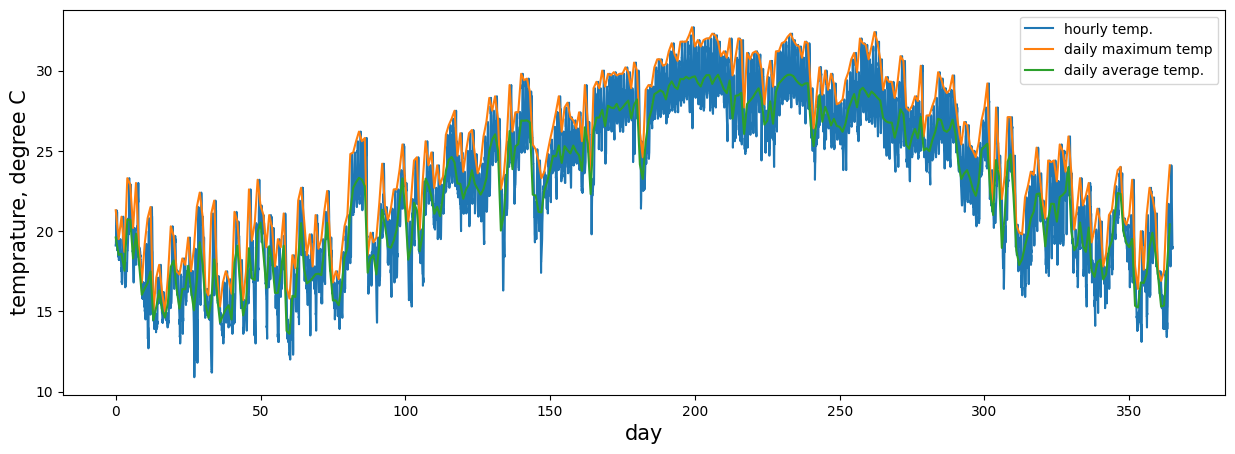

In [8]:
g = myGraph()
g.add(theta_o_h)
g.add(theta_o_max_d)
g.add(theta_o_ave_d)
g.draw()

調和関数との比較

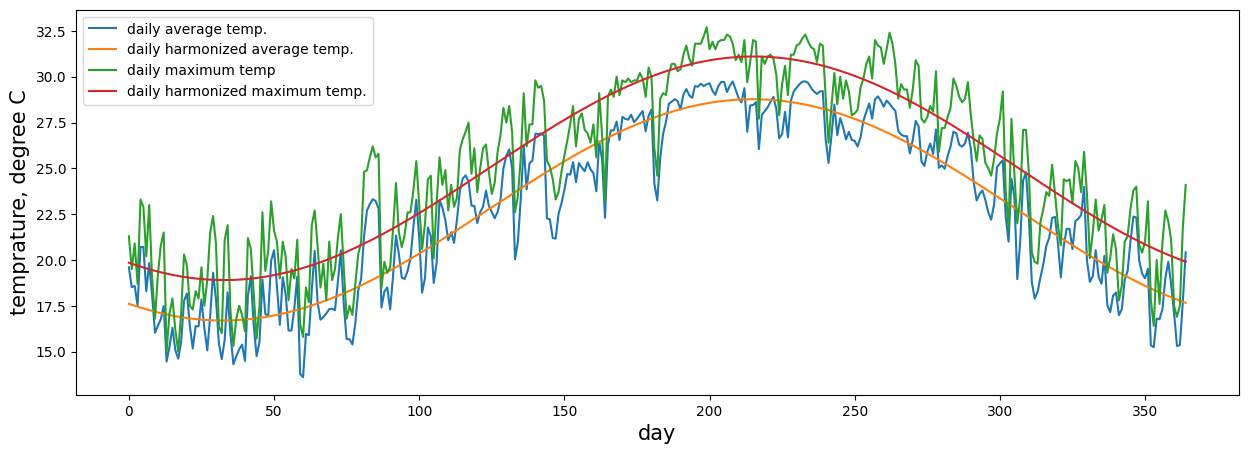

In [9]:
g = myGraph()
g.add(theta_o_ave_d)
g.add(theta_o_ave_hrm_d)
g.add(theta_o_max_d)
g.add(theta_o_max_hrm_d)
g.draw()

自作のフーリエ変換

In [10]:
def my_fft(xs):
    
    N = len(xs)
    
    def f(k):
        return np.sum([x * np.exp(-1.j * 2 * np.pi * k * n / N) for (n, x) in enumerate(xs)])
    
    return np.array([f(k) for k in range(N)])

In [11]:
def my_ifft(xs):
    
    N = len(xs)
    
    def f(n):
        return 1 / N * np.sum([x * np.exp(1.j * 2 * np.pi * k * n / N) for (k, x) in enumerate(xs)])
    
    return np.array([f(n) for n in range(N)])

自作のフーリエ変換を用いて調和関数を作成する

In [12]:
# フーリエ変換
fft_result = my_fft(xs=w.theta_o_ave_d)
# 解析結果をいれる空の箱
fft_result_filterd = np.zeros_like(a=fft_result, dtype=complex)
# 平均値成分
fft_result_filterd[0] = fft_result[0]
# n=1 成分
fft_result_filterd[1] = fft_result[1]
# n=364 成分
fft_result_filterd[-1] = fft_result[-1]
# 逆フーリエ班間（n=2～363の成分は捨てる）
theta_o_ave_my_hrm_d_raw = my_ifft(fft_result_filterd).real

theta_o_ave_my_hrm_d = (theta_o_ave_my_hrm_d_raw, "d", "daily my harmonized average temp.")


比較

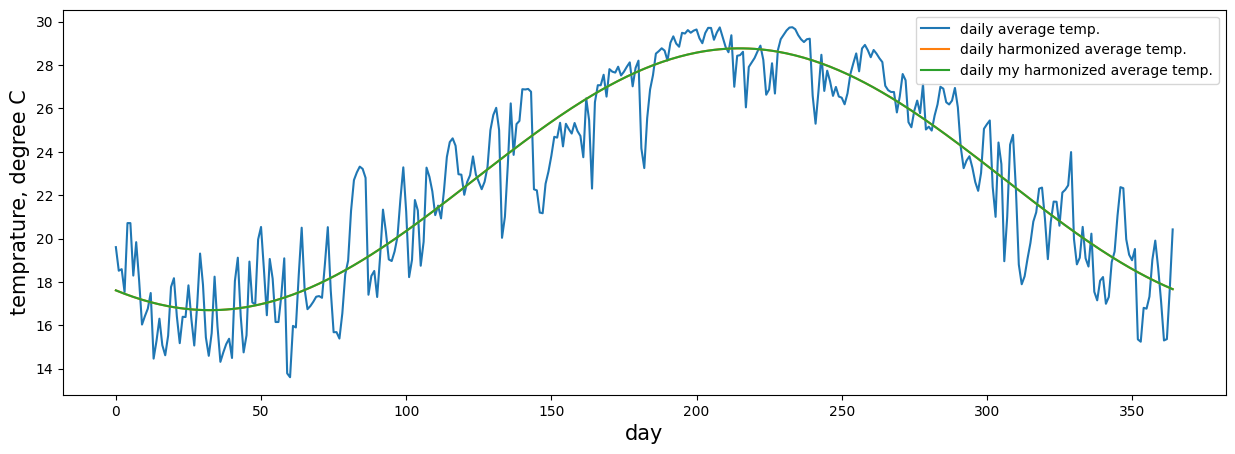

In [13]:
g = myGraph()
g.add(theta_o_ave_d)
g.add(theta_o_ave_hrm_d)
g.add(theta_o_ave_my_hrm_d)
g.draw()


自作関数とnumpy標準のfftとの差をみてみる

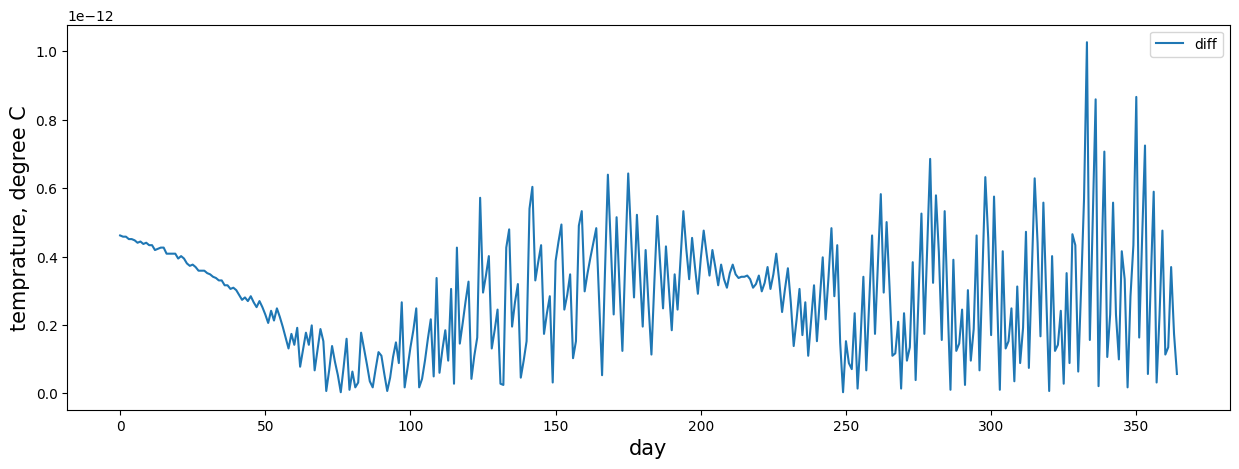

In [14]:
g = myGraph()
g.add(v=(np.abs(w.theta_o_ave_hrm_d - theta_o_ave_my_hrm_d_raw), "d", "diff"))
g.draw()

10の-11乗のレベルの誤差しかなかった。